# ViT for Electron Photon Classification

## Import libraries

In [1]:
from configs import *
import tensorflow as tf

## Construct data loaders

In [2]:
electron_features, electron_labels = get_features_and_labels(file_dir = electron_dir)
photon_features, photon_labels = get_features_and_labels(file_dir = photon_dir)
features = np.concatenate((electron_features,photon_features), axis = 0)
labels = np.concatenate((electron_labels,photon_labels), axis = 0)

In [3]:
features, labels = shuffle(features, labels, random_state=42)

In [4]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    features,
    labels,
    test_size = 0.05,
    random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(473100, 32, 32, 2)
(473100,)
(12450, 32, 32, 2)
(12450,)
(12450, 32, 32, 2)
(12450,)


In [5]:
train_loader = get_torch_data_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
val_loader = get_torch_data_loader(X_val, y_val, batch_size=batch_size, shuffle=False)

## Define model

### We are using the [vit-pytorch](https://github.com/lucidrains/vit-pytorch) library.

In [6]:
model = vit_pytorch.ViT(
    image_size=32, 
    patch_size=8, 
    num_classes=1, 
    channels=2,
    dim=64, 
    depth=8, 
    heads=10, 
    mlp_dim=128
)
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-7): 8 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=64, out_features=1920, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=640, out_features=64, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True

## Define model class for Pytorch Lightning

In [7]:
class ParticleClassifierLightning(pl.LightningModule):
  def __init__(self):
    super(ParticleClassifierLightning, self).__init__()
    self.model = model
    self.loss = nn.BCELoss()

  def forward(self, x):
    return F.sigmoid(self.model(x))

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x).squeeze()
    loss = self.loss(y_hat, y)
    auc = roc_auc_score(y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())
    self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True)
    self.log("train_auc", auc, on_step = False, on_epoch = True, prog_bar = True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x).squeeze()
    loss = self.loss(y_hat, y)
    auc = roc_auc_score(y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())
    self.log("val_loss", loss, on_step = False, on_epoch = True, prog_bar = True)
    self.log("val_auc", auc, on_step = False, on_epoch = True, prog_bar = True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    return [optimizer]
  


## Train model

In [8]:
ckpt_callback = ModelCheckpoint(
    dirpath=weights_dir,
    filename='best_weights',
    save_top_k=1,
    verbose=True,
    monitor='val_auc',
    mode='max',
    save_weights_only=True
)
logger = CSVLogger(save_dir=logs_dir, name='lightning_logs')
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=epochs,
    callbacks=[ckpt_callback],
    enable_progress_bar=True,
    logger=logger,
    devices = 1
)
lightning_module = ParticleClassifierLightning()
trainer.fit(lightning_module, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\abhim\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory C:\Users\abhim\ml4sci-tests\vision_transformers\weights exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | ViT     | 1.5 M 
1 | loss  | BCELoss | 0     
----------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.823     Total estimated model params size (MB)
c:\Users\abhim\anaconda3\lib\site-packages\lightning_fabric\loggers\csv_logs.py:188: UserWarning: Experiment logs directory ./logs\lightning_logs\version_0 exists and is not empty. Previous log files in this directory will be dele

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\abhim\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\abhim\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 7393: 'val_auc' reached 0.72271 (best 0.72271), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 14786: 'val_auc' reached 0.73088 (best 0.73088), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 22179: 'val_auc' reached 0.74202 (best 0.74202), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 29572: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 36965: 'val_auc' reached 0.74544 (best 0.74544), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 44358: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 51751: 'val_auc' reached 0.75245 (best 0.75245), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 59144: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 66537: 'val_auc' reached 0.75777 (best 0.75777), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 73930: 'val_auc' reached 0.75899 (best 0.75899), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 81323: 'val_auc' reached 0.76247 (best 0.76247), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 88716: 'val_auc' reached 0.76337 (best 0.76337), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 96109: 'val_auc' reached 0.76556 (best 0.76556), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 103502: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 110895: 'val_auc' reached 0.76797 (best 0.76797), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 118288: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 125681: 'val_auc' reached 0.76936 (best 0.76936), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 133074: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 140467: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 147860: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 155253: 'val_auc' reached 0.76992 (best 0.76992), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 162646: 'val_auc' reached 0.77046 (best 0.77046), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 170039: 'val_auc' reached 0.77410 (best 0.77410), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 177432: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 184825: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 192218: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 199611: 'val_auc' reached 0.77465 (best 0.77465), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 207004: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 214397: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 221790: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 229183: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 236576: 'val_auc' reached 0.77501 (best 0.77501), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 243969: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 251362: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 258755: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 266148: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 273541: 'val_auc' reached 0.77557 (best 0.77557), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 280934: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 288327: 'val_auc' reached 0.77648 (best 0.77648), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 295720: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 303113: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 310506: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 317899: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 325292: 'val_auc' reached 0.77841 (best 0.77841), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 332685: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 340078: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 347471: 'val_auc' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 354864: 'val_auc' reached 0.77895 (best 0.77895), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 362257: 'val_auc' reached 0.78040 (best 0.78040), saving model to 'C:\\Users\\abhim\\ml4sci-tests\\vision_transformers\\weights\\best_weights-v10.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 369650: 'val_auc' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


## Plot learning curves

### The model does not ovefit

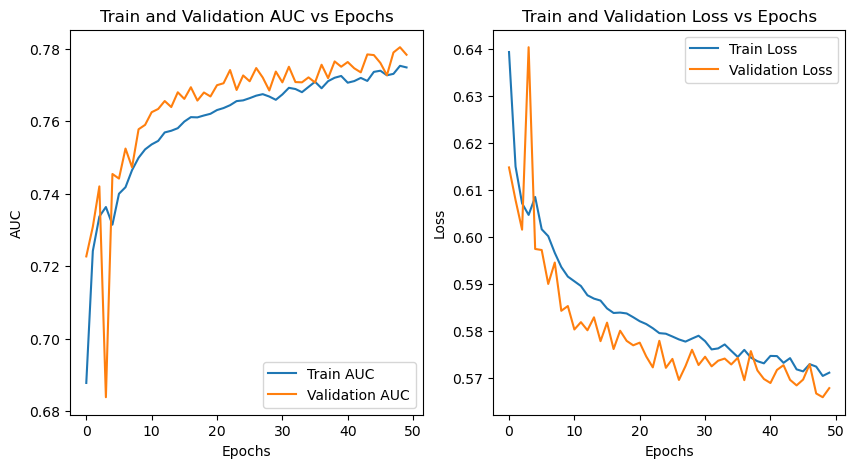

In [9]:
def plot_learning_curves(file_path):

  # Read the CSV file into a pandas DataFrame
  df = pd.read_csv(file_path, header=0)

  # Preprocess the CSV file
  epochs = np.unique(df['epoch'].dropna().values)
  val_loss = df['val_loss'].dropna().values
  val_auc = df['val_auc'].dropna().values
  train_loss = df['train_loss'].dropna().values
  train_auc = df['train_auc'].dropna().values

  # Create the side-by-side plots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  # Plot train and validation AUC vs epochs
  ax1.plot(epochs, train_auc, label='Train AUC')
  ax1.plot(epochs, val_auc, label='Validation AUC')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('AUC')
  ax1.set_title('Train and Validation AUC vs Epochs')
  ax1.legend()

  # Plot train and validation loss vs epochs
  ax2.plot(epochs, train_loss, label='Train Loss')
  ax2.plot(epochs, val_loss, label='Validation Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.set_title('Train and Validation Loss vs Epochs')
  ax2.legend()

  plt.show()

plot_learning_curves(file_path = logs_dir + '/lightning_logs/version_0/metrics.csv')

## Plot results on test set(ViT vs CNN)

### The model gives us a decent AUC = 76 on the test set but it is less than the CNNs AUC = 0.81 on the test set as seen earlier.

ViT model:


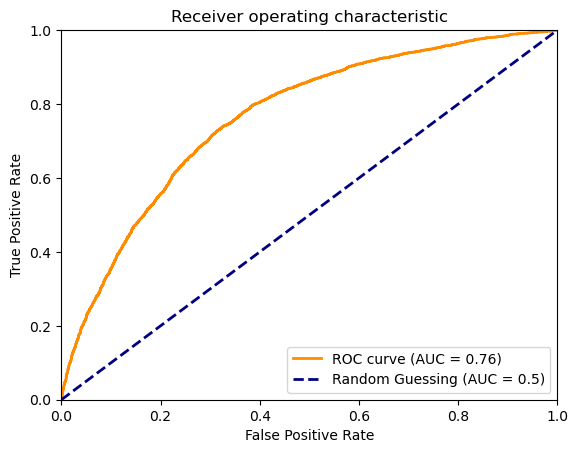

390/390 [==============================] - 8s 3ms/step
CNN model:


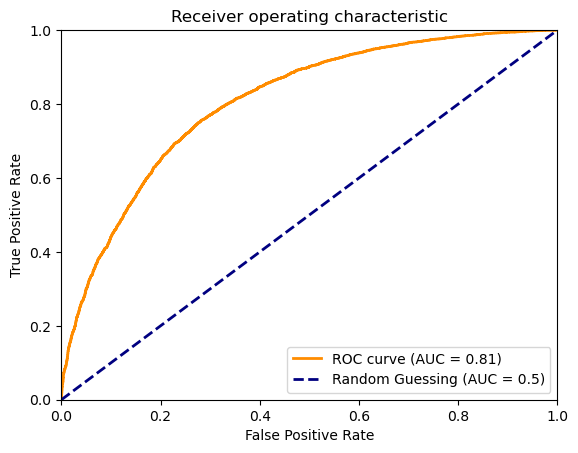

In [8]:
def plot_ROC_AUC(y_true = None, y_pred = None, precision = 4):
  
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.{}f)'.format(precision) % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guessing (AUC = 0.5)')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

def get_tflow_model():
    
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32,32,2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

best_model = ParticleClassifierLightning.load_from_checkpoint(
    checkpoint_path = weights_dir+'/best_weights-v10.ckpt'
)
best_model.eval()
predicitions = best_model(torch.from_numpy(X_test).permute(0,3,1,2))
predicitions = predicitions.detach().numpy()
print('ViT model:')
plot_ROC_AUC(y_test, predicitions, precision=2)

tf_model = get_tflow_model()
tf_model.load_weights('../common_task_1/weights_tf/best_weights')
predicitions = tf_model.predict(X_test)
print('CNN model:')
plot_ROC_AUC(y_test, predicitions, precision=2)

## Discussion

### In this experiment, we compared the performance of a Vision Transformer (ViT) and a Convolutional Neural Network (CNN) for particle identification tasks in the context of the CMS experiment at the Large Hadron Collider. The ViT model, with 1.5 million parameters, achieved an AUC of 0.76 on the test set, while the CNN model, with 30.5K parameters, achieved an AUC of 0.81 on the same test set. Notably, both models exhibited no overfitting, and the training set contained 473,100 samples.

The observed difference in performance between the ViT and CNN models can be attributed to the fundamental differences in their architectures and how they learn features:-

### Convolutional Neural Networks (CNNs):

CNNs are designed to exploit the spatial structure of input data, such as images, through a series of convolutional layers followed by non-linear activation functions. A typical convolution operation can be represented as:

Y(i, j) = ΣΣ(X(i + m, j + n) * K(m, n))

Here, Y(i, j) is the output feature map, X(i + m, j + n) is the input feature map, and K(m, n) is the kernel or filter, whose parameters are learned during training. The summations are performed over the kernel dimensions, m and n.

CNNs learn hierarchical representations by stacking multiple convolutional layers. This enables them to capture local features in the early layers and progressively learn higher-level abstractions in deeper layers. Theis results in inductive biases in CNNs, such as local connectivity and weight sharing, make them well-suited for grid-like data and contribute to their sample efficiency.

### Vision Transformers (ViTs):

ViTs, based on the Transformer architecture, treat input images as sequences of fixed-size patches. Each patch is flattened and linearly embedded into a fixed-dimensional vector:

z_i = MLP(x_i)

Here, z_i is the embedded vector for the i-th patch, x_i is the i-th input patch, and MLP is a multi-layer perceptron. After obtaining the embedded vectors z_i for each patch in the Vision Transformer (ViT), they are combined with positional encodings to incorporate information about the spatial position of each patch.The resulting vectors are then used as input to the Transformer layers.

ViTs leverage self-attention mechanisms to capture global context and long-range dependencies across patches. The core component of self-attention is the scaled dot-product attention, which can be computed as:

Attention(Q, K, V) = softmax(QK^T / √d) * V

Here, Q, K, and V are the query, key, and value matrices, respectively, which are learned during training and d is the dimension of the queries and keys.

The absence of explicit inductive biases in ViTs can make them less effective in capturing local features compared to CNNs. However, their ability to model global context can be advantageous in certain tasks, particularly when large training datasets are available.

To summarize, CNNs have an advanatge where you might not have much data to train on or you might not be able to perform transfer learning, such as in this case where:

a.there are not enough samples for the ViT to capture strong representations using global self attention and 

b.there is a lack of similarity between the tasks of publicly available pre-trained ViT weights and the task of particle identification making it unsuitable for fine-tuning. 

In situations where you can expect transfer learning to work well, ViTs can be a good choice. CNNs have a very powerful and useful inductive bias of the convolution operation and this is useful in limited data setting. Because ViT don't have this inductive bias, they are not as good as CNNs in limited data setting. [Reference](https://www.youtube.com/watch?v=htnJxcwJqeA&t=2236s)

This highlights the importance of carefully considering the choice of model architecture and its suitability for the specific problem and dataset. Future work could explore architectural modifications, data augmentation techniques, or pretraining strategies to improve the performance of the ViT model in this setting.


Although, one area where ViTs do outperform CNNs is in their robustness and generalizability in the presence of perturbations like Gausian noise. [Reference](https://arxiv.org/abs/2105.07581). This is demonstrated below:-

Let us add Gaussian noise to the test set and comapre the performance of the CNN and ViT models on the noisy test set.

In [9]:
def add_gaussian_noise(X, mean=0, std_factor=0.1):
  max_value = np.max(X)
  std = std_factor * max_value
  noise = np.random.normal(mean, std, X.shape)
  X_noisy = X + noise
  return X_noisy.astype(np.float32)


We find that the ViT model is more robust to noise than the CNN model.

ViT model:


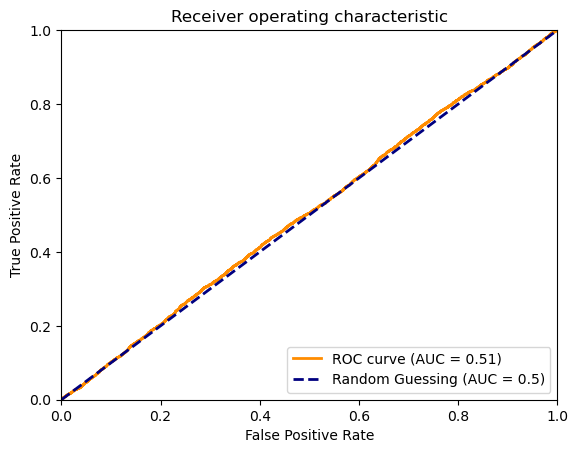

390/390 [==============================] - 2s 3ms/step
CNN model:


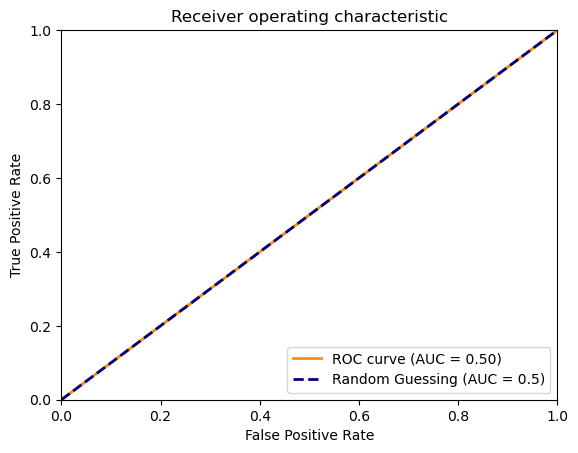

In [11]:
X_test_noisy = add_gaussian_noise(X_test)
predicitions = best_model(torch.from_numpy(X_test_noisy).permute(0,3,1,2))
predicitions = predicitions.detach().numpy()
print('ViT model:')
plot_ROC_AUC(y_test, predicitions, precision=2)

predicitions = tf_model.predict(X_test_noisy)
print('CNN model:')
plot_ROC_AUC(y_test, predicitions, precision=2)